# Murcko Scaffolds: Counting and Visualizing a List of Molecules by Scaffold

This guest post by Jeremy Monat (GitHub: [@bertiewooster](https://github.com/bertiewooster/)) provides a simple way to visualize a list of molecules by their Murcko scaffolds. Murcko scaffolds are a useful way to cluster molecules to select a chemically diverse set of molecules. Murcko scaffolds are also a good way to split a set of molecules for machine learning so the model does not train and test on molecules that have the same scaffold, which contaminates the training set.

RDKit's implementation of Murcko scaffolds is based on [Bemis-Murcko Scaffolds](https://pubmed.ncbi.nlm.nih.gov/8709122/), with [some differences](https://github.com/rdkit/rdkit/issues/4093).

In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit.Chem.Draw import MolsMatrixToGridImage
from rdkit.Chem import Descriptors

## Murcko scaffolds for a list of SMILES

Given a list of SMILES corresponding to molecules:

In [2]:
smls = [
    "Cc1cc(Oc2nccc(CCCC)c2)ccc1",
    "c1c2ccccc2ccc1",
    "Cc1cc(Oc2nccc(CCC)c2)ccc1",
    "Cc1ccccc1",
    "c1c2cc(CC)ccc2ccc1",
    "Cc1c2ccccc2ccc1",
]

we determine the Murcko scaffold for each. We put the results in a dictionary of `molecule:scaffold` format (each as a SMILES) so we can later group by scaffold. (While the scaffolds are themselves valid molecules, we use the term "molecule" here to mean an input molecule.)

In [3]:
molecule_scaffold = {sml: MurckoScaffoldSmiles(sml) for sml in smls}
molecule_scaffold

{'Cc1cc(Oc2nccc(CCCC)c2)ccc1': 'c1ccc(Oc2ccccn2)cc1',
 'c1c2ccccc2ccc1': 'c1ccc2ccccc2c1',
 'Cc1cc(Oc2nccc(CCC)c2)ccc1': 'c1ccc(Oc2ccccn2)cc1',
 'Cc1ccccc1': 'c1ccccc1',
 'c1c2cc(CC)ccc2ccc1': 'c1ccc2ccccc2c1',
 'Cc1c2ccccc2ccc1': 'c1ccc2ccccc2c1'}

Now we can determine the number of unique scaffolds by creating a `set` of the scaffolds as SMILES. (If we tried to do this with scaffold `mol`s, we wouldn't get accurate results because each `mol` is a unique object, specified by its memory address, even if it corresponds to the same structure as another `mol`.)

In [4]:
scaffolds = set(scaffold for scaffold in molecule_scaffold.values())
scaffolds

{'c1ccc(Oc2ccccn2)cc1', 'c1ccc2ccccc2c1', 'c1ccccc1'}

In [5]:
len(scaffolds)

3

## Grouping molecules by scaffold

Now we reverse the dictionary to `scaffold:list[molecule]` format to group the molecules by scaffold.

In [6]:
scaffold_molecules = dict()
for molecule, scaffold in molecule_scaffold.items():
    if scaffold not in scaffold_molecules.keys():
        scaffold_molecules[scaffold] = [molecule]
    else:
        scaffold_molecules[scaffold].append(molecule)
scaffold_molecules

{'c1ccc(Oc2ccccn2)cc1': ['Cc1cc(Oc2nccc(CCCC)c2)ccc1',
  'Cc1cc(Oc2nccc(CCC)c2)ccc1'],
 'c1ccc2ccccc2c1': ['c1c2ccccc2ccc1', 'c1c2cc(CC)ccc2ccc1', 'Cc1c2ccccc2ccc1'],
 'c1ccccc1': ['Cc1ccccc1']}

## Visualizing molecules by scaffold

To get a better sense of the scaffolds and molecules, let's plot them in rows and columns:

- Each row will correspond to a scaffold
- The first column in each row will be the scaffold
- Each subsequent column will be a molecule with that scaffold

Because each scaffold (row) can have a variable number of molecules (columns), [MolsMatrixToGridImage](https://greglandrum.github.io/rdkit-blog/posts/2023-10-25-molsmatrixtogridimage.html) is convenient for visualization.

We start by creating a matrix (nested list) of mols where the first column is the scaffold and subsequent columns are molecules with that scaffold.

In [7]:
molsMatrix = []
for scaffold, molecules_list in scaffold_molecules.items():
    molsMatrix.append(
        [Chem.MolFromSmiles(scaffold)]
        + [Chem.MolFromSmiles(sml) for sml in molecules_list]
    )

To put the scaffolds in a logical order, we sort them by molecular weight.

In [8]:
molsMatrix.sort(key=lambda row: Descriptors.MolWt(row[0]))

We loop through the rows (scaffolds) and do three things to make it easier to compare the molecules for each scaffold:

- Sort the molecules by molecular weight
- Prepare to highlight the scaffold in each molecule by getting the substructure match for each molecule
- Align the molecules so they're in the same orientation as the scaffold

Again, we use the term "molecules" to exclude the scaffold, hence the definition `molecules = row[1:]` because the scaffold is the first column in each row.

In [9]:
highlightAtomListsMatrix = []
for row in molsMatrix:
    scaffold_mol = row[0]
    molecules = row[1:]

    # Sort the molecules in the row by molecular weight (excluding the scaffold)
    molecules = sorted(molecules, key=Descriptors.MolWt)
    row[:] = [scaffold_mol] + molecules

    # Highlight the scaffold in each molecule; don't highlight the scaffold (first column)
    matches = [()] + [
        molecule.GetSubstructMatch(scaffold_mol) for molecule in molecules
    ]
    highlightAtomListsMatrix.append(matches)

    # Align the molecules so they're in the same orientation as the scaffold
    Chem.Compute2DCoords(scaffold_mol)
    for molecule in molecules:
        Chem.GenerateDepictionMatching2DStructure(molecule, scaffold_mol)

For the last setup step, we create the legends by row (scaffold):
- In the first column, we number each scaffold
- In the second column, we tell how many molecules correspond to that scaffold

In [10]:
legendsMatrix = []
for row_num, row in enumerate(molsMatrix, start=1):
    n_examples = len(row) - 1
    if n_examples == 1:
        descr = "1 molecule"
    else:
        descr = f"{n_examples} molecules"
    labelsRow = [f"Scaffold #{row_num}", descr]
    labelsRow += [""] * (n_examples - 1)
    legendsMatrix.append(labelsRow)

Now we can plot the results:

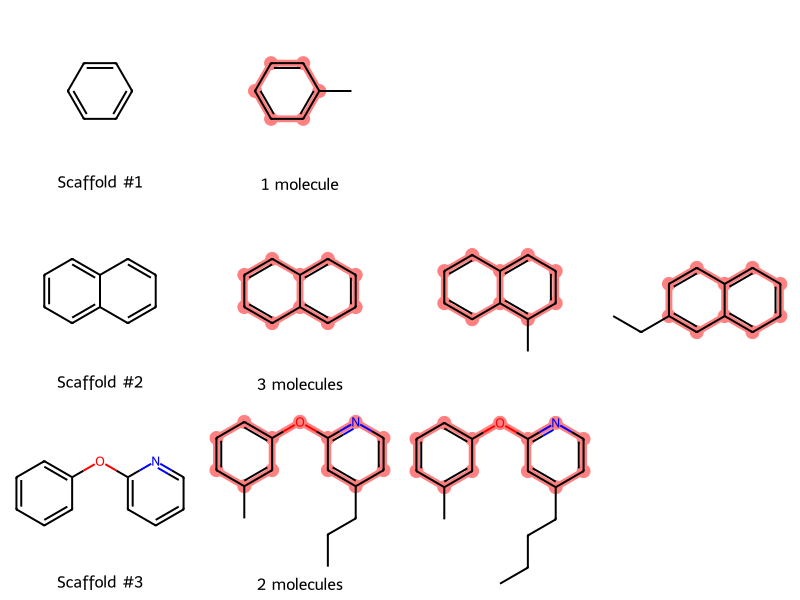

In [11]:
MolsMatrixToGridImage(
    molsMatrix=molsMatrix,
    legendsMatrix=legendsMatrix,
    highlightAtomListsMatrix=highlightAtomListsMatrix,
)